# Mesh refinement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv, det
from scipy.optimize import brentq

## Newtonian, 1d, single layer

In [ ]:
# set gravity and adiabatic index
g = 1.
gamma = 5./3.

# define grids
nx = 500
nt = 2000
ng = 2
xmin = 0.
xmax = 10.
r = 2 # refinement ratio
cfl = 0.1
df = 0.4 # size of fine grid as a fraction of coarse grid size
rho = 1.

# coarse grid
xc = np.linspace(xmin, xmax, num=nx, endpoint=False) # values of x at boundaries
qc = np.zeros((nt+1, nx, 2))
dxc = xc[1] - xc[0]
dtc = cfl * dxc
# now shift to centres
xc += 0.5 * dxc

# fine grid for inner quarter
xf = np.linspace(0.5*(1.-df)*(xmax-xmin)+xmin, 0.5*(1.+df)*(xmax-xmin)+xmin, num=int(r*df*nx), endpoint=False)
qf = np.zeros((nt+1, int(r*df*nx), 3))
dxf = xf[1] - xf[0]
dtf = cfl * dxf
# now shift to centres
xf += 0.5 * dxf

dt = min(dtc, r*dtf) # dt for coarse grid - fine grid subcycles r times per coarse timestep

print('dxc: {}, dxf: {}'.format(dxc, dxf))
#print(xc)
#print(xf)

# indices in coarse grid of cells at start of fine grid and right of end of fine grid
matching_indices = [int(np.ceil(nx*0.5*(1-df))), int(np.ceil(nx*0.5*(1+df)))]
print(matching_indices, xc[matching_indices[0]], xf[0], xc[matching_indices[1]], xf[-1])

In [ ]:
def bcs(grid):
    # outflow boundary conditions 
    grid[:ng,:] = grid[ng,:]
    grid[-ng:,:] = grid[-ng-1,:]

In [ ]:
# Start off with an initial water hill
qc[0,:,0] = 1. + 0.4 * np.exp(-(xc-5.)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
bcs(qc[0,:,:])
#print(qc[0,:])

In [ ]:
def phi(r):
    #ph = np.zeros_like(r)
    
    # MC limiter 
    return np.maximum(0.0, np.minimum(1,2.*r), np.minimum(2., r))
    # superbee limiter is not symmetric?
    """for i, rr in enumerate(r):
        if rr >= 1.:
            ph[i] = np.minimum(2., np.minimum(rr, 2./(1.+rr)))
        elif rr >= 0.5:
            ph[i] = 1.
        elif rr > 0:
            ph[i] = 2. * rr
        else:
            ph[i] = 0.
    return ph"""
        
def prolong(q_c, q_f):
    # coarse to fine 
    
    # first convert from SWE conserved variables to compressible conserved variables 
    # (h, hu) -> (rho, rho u, E)
    qc_comp = np.zeros((nx, 3))
    qc_comp[:,0] = rho
    qc_comp[:,1] = rho * q_c[:,1] / q_c[:,0]
    qc_comp[:,2] = 0.5 * rho * (g * q_c[:,0]**2 / (gamma - 1.) + q_c[:,1]**2/q_c[:,0]**2)
    
    # need to use slope limited upwinding to predict

    for s, c in enumerate(range(matching_indices[0], matching_indices[1])):
        # average slope
        S_upwind = (qc_comp[c+1,:] - qc_comp[c,:])  /dxc
        S_downwind = (qc_comp[c,:] - qc_comp[c-1,:]) / dxc
        S = 0.5 * (S_upwind + S_downwind)
        # ratio of slopes
        r = np.ones_like(S) * 1.e6
        r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
        # limit the slope
        S *= phi(r)
        
        q_f[2*s,:] = qc_comp[c,:] - 0.25 * dxc * S
        q_f[2*s+1,:] = qc_comp[c,:] + 0.25 * dxc * S
    
    
def restrict(q_c, q_f):
    # fine to coarse
    
    # first convert from compressible conserved variables to SWE conserved variables
    # (rho, rho u, E) -> (h, hu)
    qf_sw = np.zeros((len(q_f[:,0]), 2))
    qf_sw[:,0] = np.sqrt(2. * (gamma - 1.) * (q_f[:,2] - 0.5 * q_f[:,1]**2 / q_f[:,0]) / (q_f[:,0] * g))
    qf_sw[:,1] = qf_sw[:,0] * q_f[:,1] / q_f[:,0]
    
    # don't copy back the outermost 2 cells - treat these as ghost cells
    for f, c in enumerate(range(matching_indices[0]+1, matching_indices[1]-1)):
        # just use simple averaging
        q_c[c,:] = 0.5 * (qf_sw[(f+1)*2,:] + qf_sw[(f+1)*2+1,:])

In [ ]:
def evolve(q, flux_func, dx):
    
    # shallow water 

    q_p = np.zeros_like(q[1:-1,:])
    q_m = np.zeros_like(q[1:-1,:])
    
    f_p = np.zeros_like(q[1:-1,:])
    f_m = np.zeros_like(q[1:-1,:])
    
    S_upwind = (q[2:,:] - q[1:-1,:]) / dx
    S_downwind = (q[1:-1,:] - q[:-2,:]) / dx
    S = 0.5 * (S_upwind + S_downwind)
    #print(S)
    r = np.ones_like(S) * 1.e6
    r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    ph = np.zeros_like(r)
    for i in range(len(ph[:,0])):
        ph[i,:] = phi(r[i,:])
    S *= ph
    #print(S)
    
    q_p = q[1:-1,:] + S * 0.5 * dx
    q_m = q[1:-1,:] - S * 0.5 * dx
    
    #print(qc_p)
    
    # calculate fluxes at boundaries
    f_p = flux_func(q_p)
    
    f_m = flux_func(q_m)
    
    alpha = cfl * dx / dt
    
    # Lax-Friedrichs flux
    F_m = 0.5 * (f_p[:-2,:] + f_m[1:-1,:] + alpha * (q_p[:-2,:] - q_m[1:-1,:]))
    F_p = 0.5 * (f_p[1:-1,:] + f_m[2:,:] + alpha * (q_p[1:-1,:] - q_m[2:,:]))
    
    F = np.zeros_like(q)
    
    F[2:-2,:] = -alpha * (F_p - F_m) / dx
    
    #if flux_func == shallow_water_fluxes:
    bcs(F)
    
    return F

In [ ]:
def shallow_water_fluxes(q):
    # f = (hu, hu**2 + 0.5*g*h**2)
    f = np.zeros_like(q)
    f[:,0] = q[:,1]
    f[:,1] = q[:,1]**2 / q[:,0] + 0.5 * g * q[:,0]**2
    
    return f

def compressible_fluxes(q):
    # f = (rho*u, rho*u**2 + p, (E+p)*u)
    f = np.zeros_like(q)
    p = (gamma - 1.) * (q[:,2] - 0.5 * q[:,1]**2 / q[:,0])
    f[:,0] = q[:,1]
    f[:,1] = q[:,1]**2 / q[:,0] + p
    f[:,2] = (q[:,2] + p) * q[:,1] / q[:,0]
    
    return f

In [ ]:
def rk3(q, d_t, flux_func, dx):
    # third order runge-kutta
    F = evolve(q[:,:], flux_func, dx)
    
    q_temp = q[:,:] + d_t * F
    
    F = evolve(q_temp, flux_func, dx)
    
    q_temp = 0.25 * (3. * q[:,:] + q_temp + d_t * F)
    
    F = evolve(q_temp, flux_func, dx)
    
    return (q[:,:] + 2. * q_temp + 2. * d_t * F) / 3.

In [ ]:
prolong(qc[0,:,:], qf[0,:,:])

for t in range(nt):
    
    # prolong to fine grid 
    prolong(qc[t,:,:], qf[t+1,:,:])
    
    # evolve fine grid through 2 subcycles 
    for i in range(r):
        qf[t+1,:,:] = rk3(qf[t+1,:,:], dt/r, compressible_fluxes, dxf)
        
    # restrict to coarse grid 
    qc[t+1,:,:] = qc[t,:,:]
    restrict(qc[t+1,:,:], qf[t+1,:,:])
    
    # evolve coarse grid
    #qc[t+1,:,:] = qc[t,:,:]
    qc[t+1,:,:] = rk3(qc[t+1,:,:], dt, shallow_water_fluxes, dxc)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(3,7), ylim=(0.9995, 1.0005))#xlim=(0,10)), ylim=(1.,1.4))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
line = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(xf, qf[i*10,:,0])
    #return line

anim = animation.FuncAnimation(fig, animate, frames=int(nt/10), interval=25)#, blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
#for t in range(nt):
#    qc[t+1,:,:] = qc[t,:,:]
#    restrict(qc[t+1,:,:], qf[t+1,:,:])

fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(1.,1.4))
plt.xlabel(r'$x$')
plt.ylabel(r'$h$')
line = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(xc, qc[i*10,:,0])
    #return line

anim = animation.FuncAnimation(fig, animate, frames=int(nt/10), interval=25)#, blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
# check prolong and restrict work
prolong(qc[0,:,:], qf[0,:,:])
print(qc[0,:,:])
print(qf[0,:,:])
restrict(qc[0,:,:], qf[0,:,:])
print(qc[0,:,:])
print(qf[0,:,:]) 

## Newtonian, 2d, single layer

In [2]:
# set gravity and adiabatic index
g = 1.
gamma = 5./3.

# define grids
nx = 150
ny = 150
nt = 800
ng = 2
xmin = 0.
xmax = 10.
ymin = 0.
ymax = 10.
r = 2 # refinement ratio
cfl = 0.1
df = 0.4 # size of fine grid as a fraction of coarse grid size
rho = 1.

# coarse grid
xc = np.linspace(xmin, xmax, num=nx, endpoint=False) # values of x at left boundaries
yc = np.linspace(ymin, ymax, num=ny, endpoint=False) # values of y at top boundaries
qc = np.zeros((nt+1, nx, ny, 3))
dxc = xc[1] - xc[0]
dyc = yc[1] - yc[0]
dtc = cfl * min(dxc, dyc)
# now shift to centres
xc += 0.5 * dxc
yc += 0.5 * dyc

# fine grid 
xf = np.linspace(0.5*(1.-df)*(xmax-xmin)+xmin, 0.5*(1.+df)*(xmax-xmin)+xmin, num=int(r*df*nx), endpoint=False)
yf = np.linspace(0.5*(1.-df)*(ymax-ymin)+ymin, 0.5*(1.+df)*(ymax-ymin)+ymin, num=int(r*df*ny), endpoint=False)
qf = np.zeros((nt+1, int(r*df*nx), int(r*df*ny), 4))
dxf = xf[1] - xf[0]
dyf = yf[1] - yf[0]
dtf = cfl * min(dxf, dyf)
# now shift to centres
xf += 0.5 * dxf
yf += 0.5 * dyf

dt = min(dtc, r*dtf) # dt for coarse grid - fine grid subcycles r times per coarse timestep

#print('dxc: {}, dxf: {}'.format(dxc, dxf))
#print(xc)
#print(xf)

# indices in coarse grid of cells at start of fine grid and right of end of fine grid
matching_indices = np.array([[int(np.ceil(nx*0.5*(1-df))), int(np.ceil(nx*0.5*(1+df)))],
                    [int(np.ceil(ny*0.5*(1-df))), int(np.ceil(ny*0.5*(1+df)))]])
#print(matching_indices, xc[matching_indices[0]], xf[0], xc[matching_indices[1]], xf[-1])

def bcs(grid):
    # outflow boundary conditions 
    grid[:ng,:,:] = grid[ng,:,:]
    grid[-ng:,:,:] = grid[-ng-1,:,:]
    
    grid[:,:ng,:] = grid[:,ng,np.newaxis,:]
    grid[:,-ng:,:] = grid[:,-ng-1,np.newaxis,:]
    
    
# Start off with an initial water hill
qc[0,:,:,0] = 1. + 0.4 * np.exp(-((xc[:,np.newaxis]-5.)**2 + (yc[np.newaxis,:]-5.)**2)*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
bcs(qc[0,:,:,:])
#print(qc[0,:])

In [3]:
def evolve(q, flux_func, dx, dy):
    
    # shallow water 

    qx_p = np.zeros_like(q[1:-1,1:-1,:])
    qx_m = np.zeros_like(q[1:-1,1:-1,:])
    
    fx_p = np.zeros_like(q[1:-1,1:-1,:])
    fx_m = np.zeros_like(q[1:-1,1:-1,:])
    
    qy_p = np.zeros_like(q[1:-1,1:-1,:])
    qy_m = np.zeros_like(q[1:-1,1:-1,:])
    
    fy_p = np.zeros_like(q[1:-1,1:-1,:])
    fy_m = np.zeros_like(q[1:-1,1:-1,:])
    
    # x-direction
    S_upwind = (q[2:,1:-1,:] - q[1:-1,1:-1,:]) / dx
    S_downwind = (q[1:-1,1:-1,:] - q[:-2,1:-1,:]) / dx
    S = 0.5 * (S_upwind + S_downwind)
    r = np.ones_like(S) * 1.e6
    r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    ph = np.zeros_like(r)
    for i in range(len(ph[:,0])):
        ph[i,:] = phi(r[i,:])
    S *= ph
    
    qx_p = q[1:-1,1:-1,:] + S * 0.5 * dx
    qx_m = q[1:-1,1:-1,:] - S * 0.5 * dx
    
    # y-direction
    S_upwind = (q[1:-1,2:,:] - q[1:-1,1:-1,:]) / dy
    S_downwind = (q[1:-1,1:-1,:] - q[1:-1,:-2,:]) / dy
    S = 0.5 * (S_upwind + S_downwind)
    r = np.ones_like(S) * 1.e6
    r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    ph = np.zeros_like(r)
    for i in range(len(ph[:,0])):
        ph[i,:] = phi(r[i,:])
    S *= ph
    
    qy_p = q[1:-1,1:-1,:] + S * 0.5 * dy
    qy_m = q[1:-1,1:-1,:] - S * 0.5 * dy
        
    # calculate fluxes at boundaries
    fx_p = flux_func(qx_p)   
    fx_m = flux_func(qx_m)
    fy_p = flux_func(qy_p, x_dir=False)   
    fy_m = flux_func(qy_m, x_dir=False)
    
    alpha = cfl * min(dx, dy) / dt
    
    # Lax-Friedrichs flux
    Fx_m = 0.5 * (fx_p[:-2,1:-1,:] + fx_m[1:-1,1:-1,:] + alpha * (qx_p[:-2,1:-1,:] - qx_m[1:-1,1:-1,:]))
    Fx_p = 0.5 * (fx_p[1:-1,1:-1,:] + fx_m[2:,1:-1,:] + alpha * (qx_p[1:-1,1:-1,:] - qx_m[2:,1:-1,:]))
    Fy_m = 0.5 * (fy_p[1:-1,:-2,:] + fy_m[1:-1,1:-1,:] + alpha * (qy_p[1:-1,:-2,:] - qy_m[1:-1,1:-1,:]))
    Fy_p = 0.5 * (fy_p[1:-1,1:-1,:] + fy_m[1:-1,2:,:] + alpha * (qy_p[1:-1,1:-1,:] - qy_m[1:-1,2:,:]))
    
    F = np.zeros_like(q)
    
    F[2:-2,2:-2,:] = -alpha * ((Fx_p - Fx_m) / dx + (Fy_p - Fy_m) / dy)
    
    #if flux_func == shallow_water_fluxes:
    bcs(F)
    
    return F

In [4]:
def shallow_water_fluxes(q, x_dir=True):
    # f = (hu, hu**2 + 0.5*g*h**2, huv)
    f = np.zeros_like(q)
    if x_dir:
        f[:,:,0] = q[:,:,1]
        f[:,:,1] = q[:,:,1]**2 / q[:,:,0] + 0.5 * g * q[:,:,0]**2
        f[:,:,2] = q[:,:,1]*q[:,:,2] / q[:,:,0]
    else:
        f[:,:,0] = q[:,:,2]
        f[:,:,1] = q[:,:,1]*q[:,:,2] / q[:,:,0]
        f[:,:,2] = q[:,:,2]**2 / q[:,:,0] + 0.5 * g * q[:,:,0]**2
    return f

def compressible_fluxes(q, x_dir=True):
    # f = (rho*u, rho*u**2 + p, (E+p)*u)
    f = np.zeros_like(q)
    p = (gamma - 1.) * (q[:,:,3] - 0.5 * (q[:,:,1]**2 + q[:,:,2]**2) / q[:,:,0])
    if x_dir:
        f[:,:,0] = q[:,:,1]
        f[:,:,1] = q[:,:,1]**2 / q[:,:,0] + p
        f[:,:,2] = q[:,:,1]*q[:,:,2] / q[:,:,0]
        f[:,:,3] = (q[:,:,3] + p) * q[:,:,1] / q[:,:,0]
    else:
        f[:,:,0] = q[:,:,1]
        f[:,:,1] = q[:,:,1]*q[:,:,2] / q[:,:,0]
        f[:,:,2] = q[:,:,2]**2 / q[:,:,0] + p
        f[:,:,3] = (q[:,:,3] + p) * q[:,:,1] / q[:,:,0]
    
    return f

In [5]:
def rk3(q, d_t, flux_func, dx, dy):
    # third order runge-kutta
    F = evolve(q, flux_func, dx, dy)
    
    q_temp = q + d_t * F
    
    F = evolve(q_temp, flux_func, dx, dy)
    
    q_temp = 0.25 * (3. * q + q_temp + d_t * F)
    
    F = evolve(q_temp, flux_func, dx, dy)
    
    return (q + 2. * q_temp + 2. * d_t * F) / 3.

In [6]:
def phi(r):
    # MC limiter 
    return np.maximum(0.0, np.minimum(1,2.*r), np.minimum(2., r))
        
def prolong(q_c, q_f):
    # coarse to fine 
    
    # first convert from SWE conserved variables to compressible conserved variables 
    # (h, hu, hv) -> (rho, rho u, rho v, E)
    qc_comp = np.zeros((nx, ny, 4))
    qc_comp[:,:,0] = rho
    qc_comp[:,:,1] = rho * q_c[:,:,1] / q_c[:,:,0]
    qc_comp[:,:,2] = rho * q_c[:,:,2] / q_c[:,:,0]
    qc_comp[:,:,3] = 0.5 * rho * (g * q_c[:,:,0]**2 / (gamma - 1.) + (q_c[:,:,1]**2 + q_c[:,:,2]**2)/q_c[:,:,0]**2)
    
    # need to use slope limited upwinding to predict

    # x-dir
    Sx = np.zeros_like(qc_comp)
    for s, c in enumerate(range(matching_indices[0,0], matching_indices[0,1])):
        # average slope
        S_upwind = (qc_comp[c+1,:,:] - qc_comp[c,:,:])  /dxc
        S_downwind = (qc_comp[c,:,:] - qc_comp[c-1,:,:]) / dxc
        Sx[c,:,:] = 0.5 * (S_upwind + S_downwind)
        # ratio of slopes
        r = np.ones_like(Sx[0,:,:]) * 1.e6
        r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
        # limit the slope
        Sx[c,:,:] *= phi(r)
      
    # y-dir
    Sy = np.zeros_like(qc_comp)
    for s, c in enumerate(range(matching_indices[1,0], matching_indices[1,1])):
        # average slope
        S_upwind = (qc_comp[:,c+1,:] - qc_comp[:,c,:]) / dyc
        S_downwind = (qc_comp[:,c,:] - qc_comp[:,c-1,:]) / dyc
        Sy[:,c,:] = 0.5 * (S_upwind + S_downwind)
        # ratio of slopes
        r = np.ones_like(Sy[:,0,:]) * 1.e6
        r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
        # limit the slope
        Sy[:,c,:] *= phi(r)
        
    
    for s, c in enumerate(range(matching_indices[0,0], matching_indices[0,1])):    
        for t, d in enumerate(range(matching_indices[1,0], matching_indices[1,1])):
            # is this correct or should I be adding in quadrature somehow???
            q_f[2*s,2*t,:] = qc_comp[c,d,:] - 0.25 * (dxc * Sx[c,d,:] + dyc * Sy[c,d,:])
            q_f[2*s+1,2*t,:] = qc_comp[c,d,:] + 0.25 * (dxc * Sx[c,d,:] - dyc * Sy[c,d,:])
            q_f[2*s,2*t+1,:] = qc_comp[c,d,:] + 0.25 * (-dxc * Sx[c,d,:] + dyc * Sy[c,d,:])
            q_f[2*s+1,2*t+1,:] = qc_comp[c,d,:] + 0.25 * (dxc * Sx[c,d,:] + dyc * Sy[c,d,:])
    
    
def restrict(q_c, q_f):
    # fine to coarse
    
    # first convert from compressible conserved variables to SWE conserved variables
    # (rho, rho u, rho v, E) -> (h, hu, hv)
    qf_sw = np.zeros((len(q_f[:,0,0]), len(q_f[0,:,0]), 3))
    qf_sw[:,:,0] = np.sqrt(2. * (gamma - 1.) * (q_f[:,:,3] - 0.5 * (q_f[:,:,1]**2 + q_f[:,:,2]**2) / q_f[:,:,0]) 
                           / (q_f[:,:,0] * g))
    qf_sw[:,:,1] = qf_sw[:,:,0] * q_f[:,:,1] / q_f[:,:,0]
    qf_sw[:,:,2] = qf_sw[:,:,0] * q_f[:,:,2] / q_f[:,:,0]
    
    # don't copy back the outermost 2 cells - treat these as ghost cells
    for f, c in enumerate(range(matching_indices[0,0]+1, matching_indices[0,1]-1)):
        for a, d in enumerate(range(matching_indices[1,0]+1, matching_indices[1,1]-1)):
            # just use simple averaging
            q_c[c,d,:] = 0.25 * (qf_sw[(f+1)*2,(a+1)*2,:] + qf_sw[(f+1)*2+1,(a+1)*2,:] +
                                 qf_sw[(f+1)*2,(a+1)*2+1,:] + qf_sw[(f+1)*2+1,(a+1)*2+1,:])

In [7]:
prolong(qc[0,:,:,:], qf[0,:,:,:])

for t in range(nt):
    
    # prolong to fine grid 
    prolong(qc[t,:,:,:], qf[t+1,:,:,:])
    
    # evolve fine grid through 2 subcycles 
    for i in range(r):
        qf[t+1,:,:,:] = rk3(qf[t+1,:,:,:], dt/r, compressible_fluxes, dxf, dyf)
        
    # restrict to coarse grid 
    qc[t+1,:,:,:] = qc[t,:,:,:]
    restrict(qc[t+1,:,:,:], qf[t+1,:,:,:])
    
    # evolve coarse grid
    #qc[t+1,:,:] = qc[t,:,:]
    qc[t+1,:,:,:] = rk3(qc[t+1,:,:,:], dt, shallow_water_fluxes, dxc, dyc)

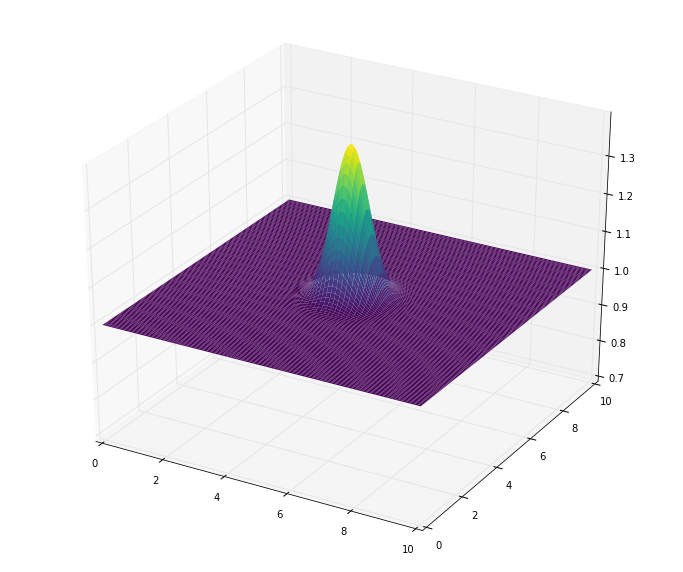

In [8]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

X,Y = np.meshgrid(xc, yc)

surface_1 = ax.plot_surface(X,Y,qc[0,:,:,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

def animate(i):
    ax.clear()
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)
    ax.set_zlim(0.7,1.4)
    ax.plot_surface(X,Y,qc[i*10,:,:,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

anim = animation.FuncAnimation(fig, animate, frames=int(nt/10), interval=40)

In [9]:
HTML(anim.to_html5_video())

## GR, 2d, single layer

In [198]:
alpha = 1.
beta = [0., 0.]
gamma_down = 1. / alpha**2 * np.eye(2)
gamma_up = inv(gamma_down)

In [11]:
def gr_shallow_water_fluxes(q, x_dir=True):
    # f = (Phi W (v-beta/alpha), Phi W**2 u (v-beta/alpha) + 0.5*Phi**2 delta_ij)
    f = np.zeros_like(q)
    W = np.sqrt((q[:,:,1]**2 * gamma_up[0,0] + 2. * q[:,:,1] * q[:,:,2] * gamma_up[0,1] + 
                 q[:,:,2]**2 * gamma_up[1,1]) / q[:,:,0]**2 + 1.)
    u = q[:,:,1] / (q[:,:,0] * W)
    v = q[:,:,2] / (q[:,:,0] * W)
    
    if x_dir:
        qx = u * gamma_up[0,0] + v * gamma_up[1,0] - beta/alpha
        
        f[:,:,0] = q[:,:,0] * qx
        f[:,:,1] = q[:,:,1] * qx + 0.5 * q[:,:,0]**2 / W**2
        f[:,:,2] = q[:,:,2] * qx
    else:
        qy = v * gamma_up[1,1] + u * gamma_up[1,0] - beta/alpha
        
        f[:,:,0] = q[:,:,0] * qy
        f[:,:,1] = q[:,:,1] * qy
        f[:,:,2] = q[:,:,2] * qy + 0.5 * q[:,:,0]**2 / W**2
    return f

def cons_to_prim(q_cons, n_x, n_y):
    # Given the conserved variables (D, Sx, Sy, tau), returns the 
    # primitive variables (rho, vx, vy, epsilon)
    q_prim = np.zeros_like(q_cons)
    D = q_prim[:,:,0]
    Sx = q_prim[:,:,1]
    Sy = q_prim[:,:,2]
    tau = q_prim[:,:,3]
    
    def f_of_p(p, i, j):
        vx = Sx[i,j] / (tau[i,j] + p)
        vy = Sy[i,j](tau[i,j] + p)
        W = 1. / np.sqrt(1. - vx**2 * gamma_up[0,0] - 2. * vx * vy * gamma_up[0,1] - vy**2 * gamma_up[1,1])
        rho = D[i,j] / W
        eps = (tau[i,j] - D[i,j] * W + p * (1. - W**2)) / (D[i,j] * W)
        
        return (gamma - 1.) * rho * eps - p
        
    p = np.zeros_like(D)
    
    for i in range(n_x):
        for j in range(n_y):
            pmin = (Sx[i,j]**2 + Sy[i,j]**2) - tau[i,j] - D[i,j]
            pmax = (gamma - 1.) * tau
            if pmin < 0.:
                pmin = 0.
            if pmax < 0. or pmax < pmin:
                pmax = 1.
            p[i,j] = brentq(f_of_p, pmin, pmax, args=(i,j))
    
    vx = Sx / (tau + p)
    vy = Sy / (tau + p)
    W = 1. / np.sqrt(1. - vx**2 * gamma_up[0,0] - 2. * vx * vy * gamma_up[0,1] - vy**2 * gamma_up[1,1])
    
    q_prim[:,:,0] = D / W
    q_prim[:,:,1] = vx
    q_prim[:,:,2] = vy
    q_prim[:,:,3] = (tau - D * W + p * (1. - W**2)) / (D * W)
    
    return q_prim

def gr_compressible_fluxes(q, x_dir=True):
    # f = (rho W (v-beta/alpha), 
    #      rho h W**2 u(v-beta/alpha) + p*delta_ij, 
    #      tau * (v-beta/alpha) + p u)
    f = np.zeros_like(q)
    #p = (gamma - 1.) * (q[:,:,3] - 0.5 * (q[:,:,1]**2 + q[:,:,2]**2) / q[:,:,0])
    #h = 1
    #u = q[:,:,1] / (q[:,:,0] * W)
    #v = q[:,:,2] / (q[:,:,0] * W)
    q_prim = cons_to_prim(q)
    rho_c = q_prim[:,:,0]
    u = q_prim[:,:,1]
    v = q_prim[:,:,2]
    epsilon = q_prim[:,:,3]
    p = (gamma - 1.) * rho_c * epsilon
    
    if x_dir:
        qx = u * gamma_up[0,0] + v * gamma_up[1,0] - beta[0]/alpha
        
        f[:,:,0] = q[:,:,0] * qx
        f[:,:,1] = q[:,:,1] * qx + p
        f[:,:,2] = q[:,:,2] * qx
        f[:,:,3] = f[:,:,3] * qx + p * u
    else:
        qy = v * gamma_up[1,1] + u * gamma_up[1,0] - beta[1]/alpha 
        
        f[:,:,0] = q[:,:,0] * qy
        f[:,:,1] = q[:,:,1] * qy
        f[:,:,2] = q[:,:,2] * qy + p
        f[:,:,3] = f[:,:,3] * qx + p * v
    
    return f

In [ ]:
def phi(r):
    # MC limiter 
    return np.maximum(0.0, np.minimum(1,2.*r), np.minimum(2., r))
        
def gr_prolong(q_c, q_f):
    # coarse to fine 
    
    # first convert from SWE conserved variables to compressible conserved variables 
    # (Phi W, Phi W**2 u, Phi W**2 v) -> (rho W, rho h W**2 u, rho h W**2 v, rho h W**2 - p)
    W = np.sqrt((q_c[:,:,1]**2 * gamma_up[0,0] + 2. * q_c[:,:,1] * q_c[:,:,2] * gamma_up[0,1] + 
                 q_c[:,:,2]**2 * gamma_up[1,1]) / q_c[:,:,0]**2 + 1.)
    h = 1. # TODO: how do we calculate h and p???
    p = 1.
    qc_comp = np.zeros((nx, ny, 4))
    qc_comp[:,:,0] = rho * W
    qc_comp[:,:,1] = rho * h * W * q_c[:,:,1] / q_c[:,:,0]
    qc_comp[:,:,2] = rho * h * W * q_c[:,:,2] / q_c[:,:,0]
    # TODO: no idea how to calculate this one??
    qc_comp[:,:,3] = rho * h * W**2 -p
    
    # need to use slope limited upwinding to predict

    # x-dir
    Sx = np.zeros_like(qc_comp)
    for s, c in enumerate(range(matching_indices[0,0], matching_indices[0,1])):
        # average slope
        S_upwind = (qc_comp[c+1,:,:] - qc_comp[c,:,:])  /dxc
        S_downwind = (qc_comp[c,:,:] - qc_comp[c-1,:,:]) / dxc
        Sx[c,:,:] = 0.5 * (S_upwind + S_downwind)
        # ratio of slopes
        r = np.ones_like(Sx[0,:,:]) * 1.e6
        r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
        # limit the slope
        Sx[c,:,:] *= phi(r)
      
    # y-dir
    Sy = np.zeros_like(qc_comp)
    for s, c in enumerate(range(matching_indices[1,0], matching_indices[1,1])):
        # average slope
        S_upwind = (qc_comp[:,c+1,:] - qc_comp[:,c,:]) / dyc
        S_downwind = (qc_comp[:,c,:] - qc_comp[:,c-1,:]) / dyc
        Sy[:,c,:] = 0.5 * (S_upwind + S_downwind)
        # ratio of slopes
        r = np.ones_like(Sy[:,0,:]) * 1.e6
        r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
        # limit the slope
        Sy[:,c,:] *= phi(r)
        
    
    for s, c in enumerate(range(matching_indices[0,0], matching_indices[0,1])):    
        for t, d in enumerate(range(matching_indices[1,0], matching_indices[1,1])):
            # is this correct or should I be adding in quadrature somehow???
            q_f[2*s,2*t,:] = qc_comp[c,d,:] - 0.25 * (dxc * Sx[c,d,:] + dyc * Sy[c,d,:])
            q_f[2*s+1,2*t,:] = qc_comp[c,d,:] + 0.25 * (dxc * Sx[c,d,:] - dyc * Sy[c,d,:])
            q_f[2*s,2*t+1,:] = qc_comp[c,d,:] + 0.25 * (-dxc * Sx[c,d,:] + dyc * Sy[c,d,:])
            q_f[2*s+1,2*t+1,:] = qc_comp[c,d,:] + 0.25 * (dxc * Sx[c,d,:] + dyc * Sy[c,d,:])
    
    
def gr_restrict(q_c, q_f):
    # fine to coarse
    
    # first convert from compressible conserved variables to SWE conserved variables
    # (rho W, rho h W**2 u, rho h W**2 v, rho h W**2 - p) -> (Phi W, Phi W**2 u, Phi W**2 v)
    qf_sw = np.zeros((len(q_f[:,0,0]), len(q_f[0,:,0]), 3))
    qf_sw[:,:,0] = np.sqrt(2. * (gamma - 1.) * (q_f[:,:,3] - 0.5 * (q_f[:,:,1]**2 + q_f[:,:,2]**2) / q_f[:,:,0]) 
                           / (q_f[:,:,0] * g))
    qf_sw[:,:,1] = qf_sw[:,:,0] * q_f[:,:,1] / q_f[:,:,0]
    qf_sw[:,:,2] = qf_sw[:,:,0] * q_f[:,:,2] / q_f[:,:,0]
    
    # don't copy back the outermost 2 cells - treat these as ghost cells
    for f, c in enumerate(range(matching_indices[0,0]+1, matching_indices[0,1]-1)):
        for a, d in enumerate(range(matching_indices[1,0]+1, matching_indices[1,1]-1)):
            # just use simple averaging
            q_c[c,d,:] = 0.25 * (qf_sw[(f+1)*2,(a+1)*2,:] + qf_sw[(f+1)*2+1,(a+1)*2,:] +
                                 qf_sw[(f+1)*2,(a+1)*2+1,:] + qf_sw[(f+1)*2+1,(a+1)*2+1,:])

In [ ]:
def evolve(q, flux_func, dx, dy):
    
    # shallow water 

    qx_p = np.zeros_like(q[1:-1,1:-1,:])
    qx_m = np.zeros_like(q[1:-1,1:-1,:])
    
    fx_p = np.zeros_like(q[1:-1,1:-1,:])
    fx_m = np.zeros_like(q[1:-1,1:-1,:])
    
    qy_p = np.zeros_like(q[1:-1,1:-1,:])
    qy_m = np.zeros_like(q[1:-1,1:-1,:])
    
    fy_p = np.zeros_like(q[1:-1,1:-1,:])
    fy_m = np.zeros_like(q[1:-1,1:-1,:])
    
    # x-direction
    S_upwind = (q[2:,1:-1,:] - q[1:-1,1:-1,:]) / dx
    S_downwind = (q[1:-1,1:-1,:] - q[:-2,1:-1,:]) / dx
    S = 0.5 * (S_upwind + S_downwind)
    r = np.ones_like(S) * 1.e6
    r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    ph = np.zeros_like(r)
    for i in range(len(ph[:,0])):
        ph[i,:] = phi(r[i,:])
    S *= ph
    
    qx_p = q[1:-1,1:-1,:] + S * 0.5 * dx
    qx_m = q[1:-1,1:-1,:] - S * 0.5 * dx
    
    # y-direction
    S_upwind = (q[1:-1,2:,:] - q[1:-1,1:-1,:]) / dy
    S_downwind = (q[1:-1,1:-1,:] - q[1:-1,:-2,:]) / dy
    S = 0.5 * (S_upwind + S_downwind)
    r = np.ones_like(S) * 1.e6
    r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    ph = np.zeros_like(r)
    for i in range(len(ph[:,0])):
        ph[i,:] = phi(r[i,:])
    S *= ph
    
    qy_p = q[1:-1,1:-1,:] + S * 0.5 * dy
    qy_m = q[1:-1,1:-1,:] - S * 0.5 * dy
        
    # calculate fluxes at boundaries
    fx_p = flux_func(qx_p)   
    fx_m = flux_func(qx_m)
    fy_p = flux_func(qy_p, x_dir=False)   
    fy_m = flux_func(qy_m, x_dir=False)
    
    a = cfl * min(dx, dy) / dt
    
    # Lax-Friedrichs flux
    Fx_m = 0.5 * (fx_p[:-2,1:-1,:] + fx_m[1:-1,1:-1,:] + a * (qx_p[:-2,1:-1,:] - qx_m[1:-1,1:-1,:]))
    Fx_p = 0.5 * (fx_p[1:-1,1:-1,:] + fx_m[2:,1:-1,:] + a * (qx_p[1:-1,1:-1,:] - qx_m[2:,1:-1,:]))
    Fy_m = 0.5 * (fy_p[1:-1,:-2,:] + fy_m[1:-1,1:-1,:] + a * (qy_p[1:-1,:-2,:] - qy_m[1:-1,1:-1,:]))
    Fy_p = 0.5 * (fy_p[1:-1,1:-1,:] + fy_m[1:-1,2:,:] + a * (qy_p[1:-1,1:-1,:] - qy_m[1:-1,2:,:]))
    
    F = np.zeros_like(q)
    
    # just * alpha = sqrt(-g) / sqrt(gamma) here as these are both const in x, y
    F[2:-2,2:-2,:] = -a * alpha * ((Fx_p - Fx_m) / dx + (Fy_p - Fy_m) / dy)
    
    #if flux_func == shallow_water_fluxes:
    bcs(F)
    
    return F